In [1]:
__author__='Katherine'

%matplotlib inline

import os
import zipfile
from ftplib import FTP
import urllib
import geojson
from sas7bdat import SAS7BDAT
import pandas as pd
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

sns.set()

C:\Python27\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##NHTSA Data Acuisition##
The following cells download and proccess National Highway Traffic Safety Administration (NHTSA) data from SAS files to Pandas DataFrames.

In [2]:
#NHTSA FTP url
NHTSA_ftp = 'ftp.nhtsa.dot.gov'

#make temp directory for debug file
try:
    os.makedirs(os.path.join(os.getcwd(),'tmp'))
except:
    pass


In [28]:
#functions to download and convert NHTSA data

def convert_SAS_to_df(filename):
    with SAS7BDAT(filename) as f:
        return f.to_data_frame()

def extract_GeoJSON(row,lat_field,lng_field,timestamp=False):
    #input: FARS DataFrame row, name of latitude field, longitude field, and (optional) time field
    #output: GeoJSON Point Feature with (optional) time property
    pt = geojson.Point((row[lng_field],row[lat_field]))
    props = {}
    if timestamp:props['timestamp'] = timestamp
    return geojson.Feature(geometry=pt,properties=props)

def download_NHTSA_data(year,type='FARS'):
    debug = open(os.path.join(os.getcwd(),'tmp','debug.txt'),'a')
    #input: year to download data, type of file 'FARS' or 'GES'
    if type.lower()=='fars':
        filename = 'FARS%s.zip' % str(year)
        outfile = os.path.join(os.getcwd(),'tmp',filename)
    
        #FARS data have a couple different file names, try downloading both
        try:
            url = 'ftp://%s/%s/%s/SAS/FARS%s.zip' % (NHTSA_ftp,type.upper(),str(year),str(year))
            urllib.urlretrieve(url,outfile)
        except:
            try:
                url = 'ftp://%s/%s/%s/SAS/FSAS%s.zip' % (NHTSA_ftp,type.upper(),str(year),str(year))
                urllib.urlretrieve(url,outfile)
            except:
                debug.write("%s ERROR: Could not find FARS file for %s\n" % (dt.now(),year))
                outfile = False
                pass


                
    elif type.lower()=='ges':
        filename = 'GES%s.zip' % str(year)
        outfile = os.path.join(os.getcwd(),'tmp',filename)
                 
        ftp = FTP(NHTSA_ftp)
        ftp.login()
        ftp.cwd('GES/GES' + str(year)[2:])
        
        for filename in ftp.nlst():
            if filename.lower().split('.')[-1] == 'zip' and filename.lower().find('flat')==-1:
                 #if the file is a zipped file and not the "flat" version, download it
                 try:
                     url = 'ftp://%s/GES/%s%s/%s' % (NHTSA_ftp,type.upper(),str(year)[2:],filename)
                     urllib.urlretrieve(url,outfile)
                 except Exception as e:
                    print e
                    debug.write("%s ERROR: Could not find GES file for %s\n" % (dt.now(),year))
                    outfile = False
                    pass
            else:
                 debug.write("%s ERROR: Could not find GES file for %s\n" % (dt.now(),year))
                 outfile = False
                 
    debug.close()
    return outfile


def acquire_and_clean_NHSTA_data(year,type='FARS'):
    #outfile = download_NHTSA_data(year,type)
    outfile ='E:\\GoogleDrive\\DataSciW210\\Final\\Infastructure_Capstone\\dataAcquisition\\tmp\\FARS2014.zip'
    if os.path.isfile(outfile) and zipfile.is_zipfile(outfile):
        #if the url passed to the def exists and is a valid zip file
        #added for Linux (was creating an empty file for non-existent url downloads)
        z = zipfile.ZipFile(outfile)
        for f in z.namelist():
            #convert each SAS file to a pandas data frame
            if f.split('.')[-1] == 'sas7bdat':
                unzipped = z.extract(f) #extract the file
                df = convert_SAS_to_df(unzipped) #convert to pandas dataframe
                os.remove(unzipped) #remove extracted file

                ###KASANE'S ES CODE
                ## 
                ##
                ##
                ###


                ##This is the code for extracting geojson point records from the ACCIDENT file
##                points = []
##
##                if type.lower()=='fars' and f == 'accident.sas7bdat':
##                #Extract location and timestamp out of ACCIDENT file and load into GeoJSON point feature collection
##                    print df.columns
##                    for row_tup in df.iterrows():
##                        row = row_tup[1]
##                        timestamp = dt(int(row['YEAR']),int(row['MONTH']),int(row['DAY']),int(row['HOUR']),int(row['MINUTE']))
##                        points.append(extract_GeoJSON(row,'LATITUDE','LONGITUD',timestamp))
##                        
##                pointsfile = f.split('.')[0] + '_geojson.json' #filename for GEOJSON file
##                geojson.dump(geojson.FeatureCollection(points),os.path.join(os.getcwd(),'tmp',pointsfile))

In [29]:
acquire_and_clean_NHSTA_data(2014,'FARS') 

##NYC Collision Data Exploration##
The following cells download and explore the New York Police Department Collision Data set.

In [2]:
#temp directory for storing data
data_dir = 'E:/GoogleDrive/DataSciW210/Final/datasets'

We'll load the NYC Collision data into a Pandas DataFrame, clean up the date and time fields

In [3]:
#Load the data into a Pandas dataframe
df = pd.read_csv(os.path.join(data_dir,'NYPD_Motor_Vehicle_Collisions.csv'),parse_dates=[[0,1]],keep_date_col=True) #NYC collision data
df=df.reset_index()
print df.shape

with open(os.path.join(data_dir,'NYC_Subway_Entrances.geojson'),'r') as geo:
    subways = geojson.load(geo) #geojson file of subway entrances

(746861, 31)


In [6]:
print df.columns

Index([u'index', u'DATE_TIME', u'DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE', u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME', u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED', u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED', u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED', u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED', u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1', u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3', u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5', u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2', u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5', u'HOUR', u'MONTH', u'YEAR'], dtype='object')


In [4]:
print df.head(5)

   index           DATE_TIME        DATE   TIME   BOROUGH  ZIP CODE  \
0      0 2016-02-02 16:00:00  02/02/2016  16:00    QUEENS     11691   
1      1 2016-02-02 11:35:00  02/02/2016  11:35    QUEENS     11364   
2      2 2016-02-02 11:35:00  02/02/2016  11:35  BROOKLYN     11226   
3      3 2016-02-02 11:31:00  02/02/2016  11:31     BRONX     10460   
4      4 2016-02-02 11:30:00  02/02/2016  11:30  BROOKLYN     11215   

    LATITUDE  LONGITUDE                   LOCATION   ON STREET NAME  \
0  40.606228 -73.759776  (40.6062278, -73.7597764)     EGGERT PLACE   
1  40.755687 -73.752177  (40.7556871, -73.7521773)        53 AVENUE   
2  40.655250 -73.952960  (40.6552496, -73.9529602)    ROGERS AVENUE   
3  40.845986 -73.884467   (40.845986, -73.8844667)  EAST 180 STREET   
4  40.668030 -73.983945  (40.6680296, -73.9839446)         6 AVENUE   

          ...          CONTRIBUTING FACTOR VEHICLE 2  \
0         ...                            Unspecified   
1         ...                     

In [5]:
def night_hours(row):
    #returns 1 if hour is between 10pm and 5:59am
    if int(row.DATE_TIME.hour) >= 22 or int(row.DATE_TIME.hour) < 6: return 1
    return 0

#Add fields for the hour, month, year, and (boolean) midnight hours
df['HOUR'] = df.apply(lambda row: row.DATE_TIME.hour,axis=1)
df['MONTH'] = df.apply(lambda row: row.DATE_TIME.month,axis=1)
df['YEAR'] = df.apply(lambda row: row.DATE_TIME.year,axis=1)
df['MIDNIGHT'] = df.apply(night_hours,axis=1)
print df.head(2)


   index           DATE_TIME        DATE   TIME BOROUGH  ZIP CODE   LATITUDE  \
0      0 2016-02-02 16:00:00  02/02/2016  16:00  QUEENS     11691  40.606228   
1      1 2016-02-02 11:35:00  02/02/2016  11:35  QUEENS     11364  40.755687   

   LONGITUDE                   LOCATION ON STREET NAME  ...   \
0 -73.759776  (40.6062278, -73.7597764)   EGGERT PLACE  ...    
1 -73.752177  (40.7556871, -73.7521773)      53 AVENUE  ...    

  CONTRIBUTING FACTOR VEHICLE 5 UNIQUE KEY  VEHICLE TYPE CODE 1  \
0                           NaN    3382352                  BUS   
1                           NaN    3383151    PASSENGER VEHICLE   

             VEHICLE TYPE CODE 2  VEHICLE TYPE CODE 3  VEHICLE TYPE CODE 4  \
0  SPORT UTILITY / STATION WAGON                  NaN                  NaN   
1                  PICK-UP TRUCK                  NaN                  NaN   

   VEHICLE TYPE CODE 5  HOUR  MONTH  YEAR  
0                  NaN    16      2  2016  
1                  NaN    11      2  2016

Add columns to identify if anyone was killed or injured.

In [19]:
def any_fatality(row):
    #returns 1 if any fatality occurred
    if row['NUMBER OF PERSONS KILLED'] > 0: return 1
    return 0

def any_injury(row):
    #returns 1 if any fatality occurred
    if row['NUMBER OF PERSONS INJURED'] > 0: return 1
    return 0

df['Fatality'] = df.apply(any_fatality, axis=1)
df['Injury'] = df.apply(any_injury, axis=1)

####Exploratory Analysis - By Borough####
Now let's visualize the fatalities and injuries in the dataset.

In [24]:
#% of accidents that result in death or injury
avg_killed_by_borough = df.groupby(['BOROUGH'])['Fatality'].mean()
print avg_killed_by_borough

avg_inj_by_borough = df.groupby(['BOROUGH'])['Injury'].mean()
print avg_inj_by_borough


#filtered for accidents that occur between 10pm and 5:59am
avg_killed_at_night = df[df.MIDNIGHT==1].groupby(['BOROUGH'])['Fatality'].mean()
print avg_killed_at_night

avg_inj_at_night = df[df.MIDNIGHT==1].groupby(['BOROUGH'])['Injury'].mean()
print avg_inj_at_night

BOROUGH
BRONX            0.001330
BROOKLYN         0.001331
MANHATTAN        0.000796
QUEENS           0.001281
STATEN ISLAND    0.001380
Name: Fatality, dtype: float64
BOROUGH
BRONX            0.210652
BROOKLYN         0.219722
MANHATTAN        0.141572
QUEENS           0.188212
STATEN ISLAND    0.176826
Name: Injury, dtype: float64
BOROUGH
BRONX            0.003405
BROOKLYN         0.002835
MANHATTAN        0.001210
QUEENS           0.003032
STATEN ISLAND    0.003955
Name: Fatality, dtype: float64
BOROUGH
BRONX            0.238834
BROOKLYN         0.263737
MANHATTAN        0.175467
QUEENS           0.222216
STATEN ISLAND    0.201384
Name: Injury, dtype: float64


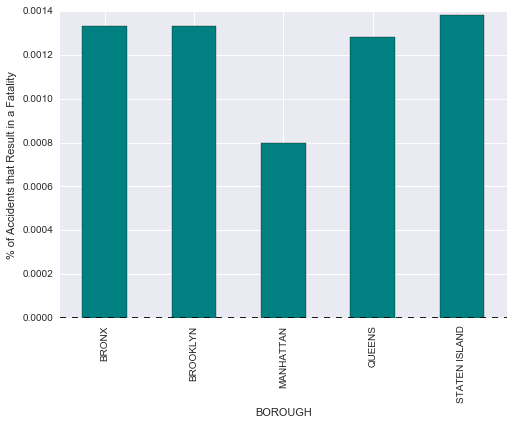

In [28]:
ax = avg_killed_by_borough.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in a Fatality')

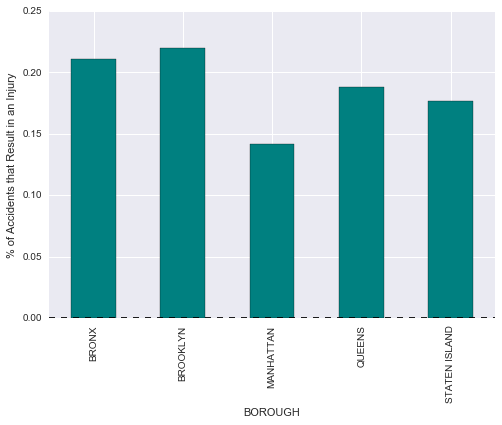

In [29]:
ax = avg_inj_by_borough.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in an Injury')

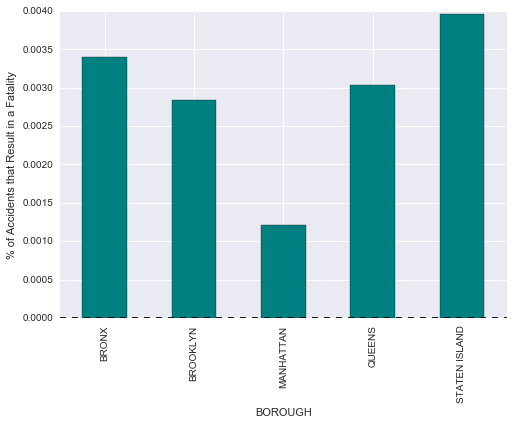

In [34]:
ax = avg_killed_at_night.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in a Fatality')

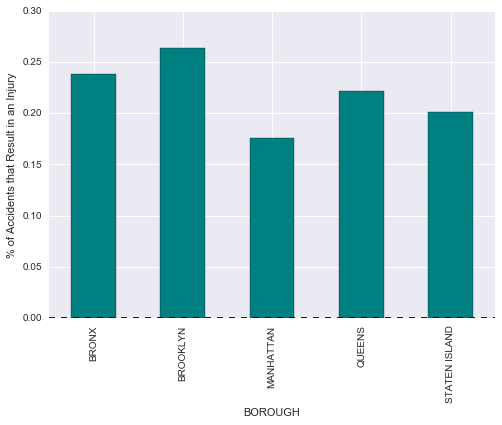

In [35]:
ax = avg_inj_at_night.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in an Injury')

####Exploratory Analysis - Time Series####
Now let's visualize the fatalities and injuries in the dataset.

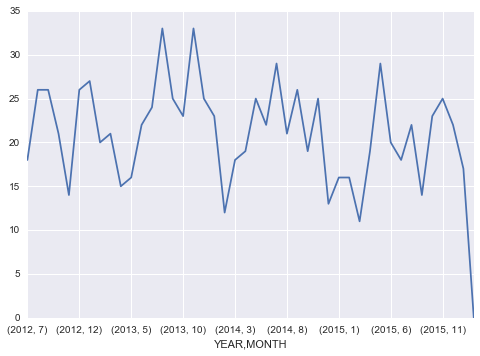

In [30]:
#Fatality accidents over time
total_killed_by_month = df.groupby(['YEAR','MONTH'])['Fatality'].sum()
ax = total_killed_by_month.plot()

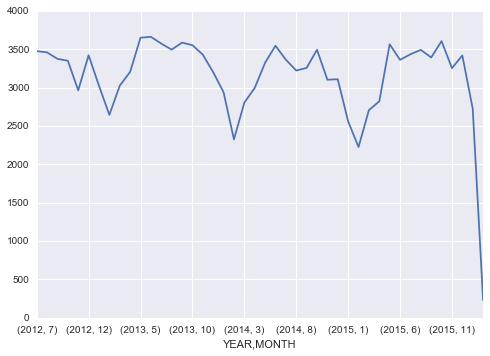

In [31]:
#Injury accidents over time
total_inj_by_month = df.groupby(['YEAR','MONTH'])['Injury'].sum()
ax = total_inj_by_month.plot()

In [33]:
def season(row):
    #returns season based on 'MONTH' field
    if row.MONTH >= 11 or row.MONTH < 4: return 'Winter'
    if row.MONTH >= 4 and row.MONTH < 7: return 'Spring'
    if row.MONTH >= 7 and row.MONTH < 10: return 'Summer'
    return 'Autumn'

#Add season based on Month
df['Season'] = df.apply(season, axis=1)

avg_killed_by_season = df.groupby(['Season'])['Fatality'].mean()
print avg_killed_by_season

avg_inj_by_season = df.groupby(['Season'])['Injury'].mean()
print avg_inj_by_season

Season
Autumn    0.001186
Spring    0.001162
Summer    0.001340
Winter    0.001202
Name: Fatality, dtype: float64
Season
Autumn    0.193179
Spring    0.187173
Summer    0.195391
Winter    0.175359
Name: Injury, dtype: float64


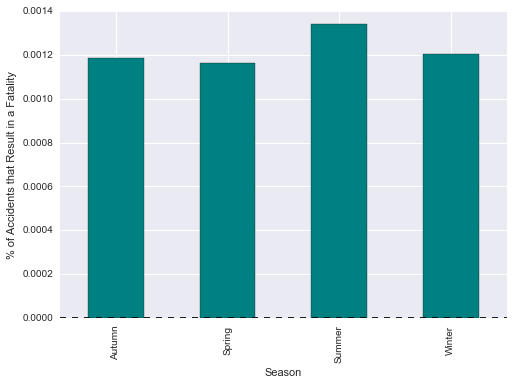

In [36]:
ax = avg_killed_by_season.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in a Fatality')

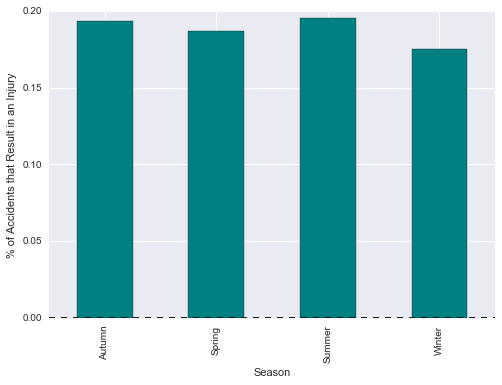

In [37]:
ax = avg_inj_by_season.plot(kind='bar',color='teal')
ax.set_ylabel('% of Accidents that Result in an Injury')

###Text Features###
Let's explore some of the text features in the dataset.

In [39]:
#make a dictionary of words in the 'Contributing Factors' columns
contr_factors = {}
for i in range(1,6):
    contr_factors[i] = {}
    for row in df.iterrows():
        for word in row[1]['CONTRIBUTING FACTOR VEHICLE %s' % i].split():
            if word not in contr_factors[i]: contr_factors[i][word]=0
            contr_factors[i][word]+=1
            


AttributeError: 'float' object has no attribute 'split'

In [38]:
print contr_factors[1]

###Weather Data Collection and Processing###